# Imports

In [1]:
from Twitter import TwitterAccess
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from collections import Counter
pd.options.display.max_colwidth = None
import nltk
import string
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from spellchecker import SpellChecker
import random
import numpy as np
from multiprocessing import  Pool

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin # ???
from sklearn.utils.validation import check_X_y, check_is_fitted # ???
from scipy import sparse #???
from sklearn.linear_model import LogisticRegression


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

[nltk_data] Downloading package stopwords to /u/arsaikia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Utils

In [2]:
def create_corpus(tweets):
    stop=set(stopwords.words('english'))
    corpus=[]
    for tweet in tqdm(tweets):
#         words=[word.lower() for word in nltk.casual_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        words=[word.lower() for word in nltk.casual_tokenize(tweet)]
        corpus.append(words)
    return corpus


def get_embedding_matrix(word_index, num_words, embedding_dim):
    embedding_dict={}
# with open('./data/glove6B/glove.6B.100d.txt','r') as f:
    with open('../data/gloveTwitter27B/glove.twitter.27B.100d.txt','r') as f:
        for line in f:
            values=line.split()
            word=values[0]
            vectors=np.asarray(values[1:],'float32')
            embedding_dict[word]=vectors
    f.close()
    
    embedding_matrix=np.zeros((num_words,embedding_dim))

    for word,i in tqdm(word_index.items()):
        if i > num_words:
            continue

        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec
    return embedding_matrix



# Architecture

In [3]:

def architecture(text, nclasses):
    corpus=create_corpus(text)

    tokenizer_obj = Tokenizer()
    tokenizer_obj.fit_on_texts(corpus) #??
    sequences = tokenizer_obj.texts_to_sequences(corpus) #??

    tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

    word_index=  tokenizer_obj.word_index
    print('Number of unique words:',len(word_index))

    num_words = len(word_index)+1

    embedding_matrix = get_embedding_matrix(word_index, num_words, embedding_dim)

    model = Sequential()

    embedding = Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                       input_length=MAX_LEN,trainable=True)

    model.add(embedding)
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    if nclasses >2 :
        model.add(Dense(nclasses, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))


    optimizer=Adam(learning_rate=1e-4)
    
    if nclasses > 2:
        model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    else:
        model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    model.summary()
    return tweet_pad, model, tokenizer_obj

# Train-Validate

In [4]:
# train=tweet_pad[:tweet.shape[0]]
# test=tweet_pad[tweet.shape[0]:]

def train_validate(X, y, model):
    le = LabelEncoder()
    y = le.fit_transform(y)
    if len(le.classes_) > 2:
        y = np_utils.to_categorical(y)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
    

    # X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
    print('Shape of train',X_train.shape)
    print("Shape of Validation ",X_valid.shape)
    callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )

    history=model.fit(X_train,y_train,
                      batch_size=512,
                      epochs=200,
                      validation_data=(X_valid,y_valid),
                      shuffle = True,
                      verbose=2,
                     callbacks = [callback])

    
    proba_valid = model.predict(X_valid)
    
    proba_train = model.predict(X_train)

    
    if len(le.classes_) > 2:
        preds_valid = (proba_valid == np.max(proba_valid, axis =1).reshape(-1,1)).astype(int)
        preds_train = (proba_train == np.max(proba_train, axis =1).reshape(-1,1)).astype(int)
        
    else:
        preds_valid = np.round(proba_valid)
        preds_train = np.round(proba_train)
    print(classification_report(y_train, preds_train))
    try:
        print('AUC: ',  roc_auc_score(y_train, proba_train))
    except:
        print('AUC: ',  roc_auc_score(y_train, proba_train, multi_class ='ovr'))
        
    print(classification_report(y_valid, preds_valid))
    try:
        print('AUC: ',  roc_auc_score(y_valid, proba_valid))
    except:
        print('AUC: ',  roc_auc_score(y_valid, proba_valid, multi_class ='ovr'))
        
    return model



# Test

In [5]:
def test(X, y, X_test, y_test, tokenizer_obj, model):
    le = LabelEncoder()
    y = le.fit_transform(y)   
    y_test = le.transform(y_test)
    if len(le.classes_) > 2:
        y = np_utils.to_categorical(y)
        y_test = np_utils.to_categorical(y_test)
    
    corpus_test = create_corpus(X_test)
    sequences_test = tokenizer_obj.texts_to_sequences(corpus_test) #??

    X_test = pad_sequences(sequences_test,maxlen=MAX_LEN,truncating='post',padding='post')

    callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )
    history=model.fit(X,y,
                      batch_size=512,
                      epochs=100,
                      validation_data=(X_test,y_test),
                      shuffle = True,
                      verbose=2,
                     callbacks = [callback])



    print(X_test.shape, y_test.shape)
    proba_test = model.predict(X_test)
    
    if len(le.classes_) > 2:
        preds_test = (proba_test == np.max(proba_test, axis =1).reshape(-1,1)).astype('int')

    else:
        preds_test = np.round(proba_test)
    
    
    print(classification_report(y_test, preds_test))
    try:
        print('AUC: ',  roc_auc_score(y_test, proba_test))
    except:
        print('AUC: ',  roc_auc_score(y_test, proba_test, multi_class ='ovr'))

# Load Data

In [6]:
PREPROCESSED = '../preprocessed/'

olid = pd.read_csv(PREPROCESSED + 'olid.csv')
olid_traina = olid[~pd.isna(olid['tweet_cleaned'])]
olid_trainb = olid_traina[~pd.isna(olid_traina['subtask_b'])]
olid_trainc = olid_traina[~pd.isna(olid_traina['subtask_c'])]


olid_testa = pd.read_csv(PREPROCESSED + 'olid-levela.csv')
olid_testa = olid_testa[~pd.isna(olid_testa['tweet_cleaned'])]

olid_testb = pd.read_csv(PREPROCESSED + 'olid-levelb.csv')
olid_testb = olid_testb[~pd.isna(olid_testb['tweet_cleaned'])]

olid_testc = pd.read_csv(PREPROCESSED + 'olid-levelc.csv')
olid_testc = olid_testc[~pd.isna(olid_testc['tweet_cleaned'])]

# Subtask A

100%|██████████| 13239/13239 [00:00<00:00, 14780.03it/s]


Number of unique words: 19059


100%|██████████| 19059/19059 [00:00<00:00, 378190.40it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1906000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,948,305
Trainable params: 1,948,305
Non-trainable params: 0
_________________________________________________________________
Shape of train (8870, 50)
Shape of Validation  (4369, 50)
Epoch 1/200
18/18 - 3s - loss: 0.6907 - accuracy: 0.6495 - val_loss: 0.6861 - val_accuracy: 0.6663
Epoch 2/200
18/18 - 2s - loss: 0.6822 - accuracy: 0.6684 - val_loss: 0.6775 - val_accur

100%|██████████| 859/859 [00:00<00:00, 8418.48it/s]

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      5922
           1       0.78      0.65      0.71      2948

    accuracy                           0.82      8870
   macro avg       0.81      0.78      0.79      8870
weighted avg       0.82      0.82      0.82      8870

AUC:  0.88446972560977
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      2917
           1       0.68      0.56      0.61      1452

    accuracy                           0.77      4369
   macro avg       0.74      0.71      0.72      4369
weighted avg       0.76      0.77      0.76      4369

AUC:  0.8118356721451433
Epoch 1/100


26/26 - 3s - loss: 0.4775 - accuracy: 0.7756 - val_loss: 0.4230 - val_accuracy: 0.8207
Epoch 2/100
26/26 - 3s - loss: 0.4727 - accuracy: 0.7799 - val_loss: 0.4265 - val_accuracy: 0.8184
Epoch 3/100
26/26 - 3s - loss: 0.4669 - accuracy: 0.7836 - val_loss: 0.4271 - val_accuracy: 0.8196
Epoch 4/100
26/26 - 3s - loss: 0.4675 - accuracy: 0.7862 - val_loss: 0.4217 - val_accuracy: 0.8207
Epoch 5/100
26/26 - 3s - loss: 0.4626 - accuracy: 0.7847 - val_loss: 0.4268 - val_accuracy: 0.8207
Epoch 6/100
26/26 - 4s - loss: 0.4635 - accuracy: 0.7830 - val_loss: 0.4240 - val_accuracy: 0.8207
Epoch 7/100
26/26 - 5s - loss: 0.4568 - accuracy: 0.7917 - val_loss: 0.4198 - val_accuracy: 0.8207
Epoch 8/100
26/26 - 4s - loss: 0.4525 - accuracy: 0.7908 - val_loss: 0.4251 - val_accuracy: 0.8184
Epoch 9/100
26/26 - 4s - loss: 0.4519 - accuracy: 0.7927 - val_loss: 0.4177 - val_accuracy: 0.8219
Epoch 10/100
26/26 - 3s - loss: 0.4484 - accuracy: 0.7939 - val_loss: 0.4222 - val_accuracy: 0.8207
Epoch 11/100
26/26 - 

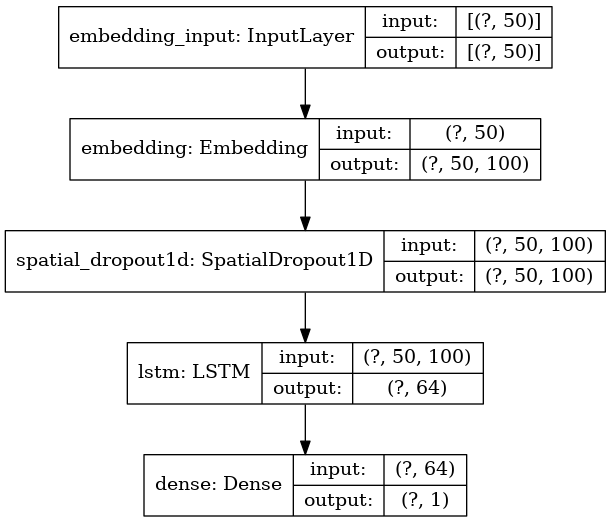

In [7]:
MAX_LEN = 50
embedding_dim = 100

tweet_pada, modela, tokenizer_obj = architecture(olid_traina['tweet_cleaned'], 2)
modela = train_validate(tweet_pada, olid_traina['subtask_a'], modela)
test(tweet_pada, olid_traina['subtask_a'], olid_testa['tweet_cleaned'], olid_testa['subtask_a'], tokenizer_obj, modela)


plot_model(modela, show_shapes=True, to_file='lstm.png')

# Subtask B

In [8]:
MAX_LEN = 50
embedding_dim = 100

tweet_padb, modelb, tokenizer_obj = architecture(olid_trainb['tweet_cleaned'], 2)
modelb = train_validate(tweet_padb, olid_trainb['subtask_b'], modelb)
test(tweet_padb, olid_trainb['subtask_b'], olid_testb['tweet_cleaned'], olid_testb['subtask_b'], tokenizer_obj, modelb)


# plot_model(modela, show_shapes=True, to_file='lstm.png')

100%|██████████| 4400/4400 [00:00<00:00, 12368.86it/s]


Number of unique words: 10272


100%|██████████| 10272/10272 [00:00<00:00, 330509.46it/s]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1027300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,069,605
Trainable params: 1,069,605
Non-trainable params: 0
_________________________________________________________________
Shape of train (2948, 50)
Shape of Validation  (1452, 50)
Epoch 1/200
6/6 - 1s - loss: 0.6986 - accuracy: 0.6645 - val_loss: 0.6931 - val_accuracy: 0.7562
Epoch 2/200
6/6 - 1s - loss: 0.6893 - accuracy: 0.7924 - val_loss: 0.6834 - val_accurac

/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 240/240 [00:00<00:00, 10505.68it/s]


              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2599
           1       0.00      0.00      0.00       349

    accuracy                           0.88      2948
   macro avg       0.44      0.50      0.47      2948
weighted avg       0.78      0.88      0.83      2948

AUC:  0.6160430890876037
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1277
           1       0.00      0.00      0.00       175

    accuracy                           0.88      1452
   macro avg       0.44      0.50      0.47      1452
weighted avg       0.77      0.88      0.82      1452

AUC:  0.642112093075288
Epoch 1/100
9/9 - 1s - loss: 0.3568 - accuracy: 0.8809 - val_loss: 0.3395 - val_accuracy: 0.8875
Epoch 2/100
9/9 - 1s - loss: 0.3582 - accuracy: 0.8809 - val_loss: 0.3389 - val_accuracy: 0.8875
Epoch 3/100
9/9 - 1s - loss: 0.3573 - accuracy: 0.8809 - val_loss: 0.3382 - val_accuracy: 0.8875
Epoch 

/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Subtask C

In [9]:
MAX_LEN = 50
embedding_dim = 100

tweet_padc, modelc, tokenizer_obj = architecture(olid_trainc['tweet_cleaned'], 3)
modelc = train_validate(tweet_padc, olid_trainc['subtask_c'], modelc)
test(tweet_padc, olid_trainc['subtask_c'], olid_testc['tweet_cleaned'], olid_testc['subtask_c'], tokenizer_obj, modelc)
# modelc.predict(tweet_padc)

# plot_model(modela, show_shapes=True, to_file='lstm.png')

100%|██████████| 3876/3876 [00:00<00:00, 11510.77it/s]


Number of unique words: 9614


100%|██████████| 9614/9614 [00:00<00:00, 440844.42it/s]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           961500    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,003,935
Trainable params: 1,003,935
Non-trainable params: 0
_________________________________________________________________
Shape of train (2596, 50)
Shape of Validation  (1280, 50)
Epoch 1/200
6/6 - 1s - loss: 1.0939 - accuracy: 0.5331 - val_loss: 1.0826 - val_accuracy: 0.6242
Epoch 2/200
6/6 - 1s - loss: 1.0839 - accuracy: 0.6059 - val_loss: 1.0753 - val_accurac

/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 213/213 [00:00<00:00, 10308.63it/s]


              precision    recall  f1-score   support

           0       0.61      0.73      0.66       735
           1       0.82      0.87      0.85      1600
           2       0.00      0.00      0.00       261

   micro avg       0.75      0.75      0.75      2596
   macro avg       0.48      0.54      0.50      2596
weighted avg       0.68      0.75      0.71      2596
 samples avg       0.75      0.75      0.75      2596

AUC:  0.8102884731494678
              precision    recall  f1-score   support

           0       0.54      0.66      0.59       339
           1       0.79      0.85      0.82       807
           2       0.00      0.00      0.00       134

   micro avg       0.71      0.71      0.71      1280
   macro avg       0.44      0.50      0.47      1280
weighted avg       0.64      0.71      0.67      1280
 samples avg       0.71      0.71      0.71      1280

AUC:  0.7596328084867187
Epoch 1/100
8/8 - 1s - loss: 0.7083 - accuracy: 0.7190 - val_loss: 0.9562 - val_

/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# thresholds for sub task B
# no learning for sub task C